<a href="https://colab.research.google.com/github/Alexis086/Alexis086/blob/master/Load_db_from_Openml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importar las librerias necesarias**

In [ ]:
from sklearn.datasets import fetch_openml
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#funcion para cargar la base de datos de Openml
def load_openmldb(n_samples=None):
    """Fetch the openml datasets

    Parameters
    ----------
    n_samples: int, default=None
      number of samples to select (for faster run time).
    """
    #cambiar el id del data set a utilizar
    #Insurance-Premium-Data from https://www.openml.org/d/43463
    df = fetch_openml(data_id=43463, as_frame=True).data
    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


In [ ]:
df = load_openmldb()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## EDA

In [ ]:
df.head(15)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


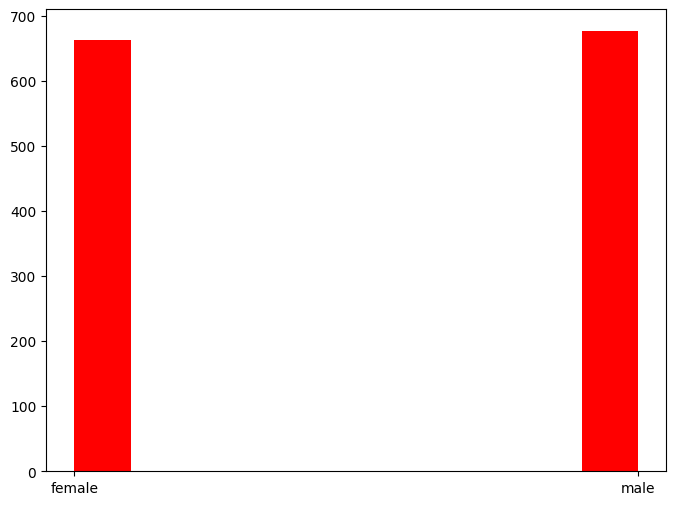

In [ ]:
# Hombres y mujeres
plt.figure(figsize=(8, 6))
ignored = plt.hist(df['sex'], color='r')
plt.show()

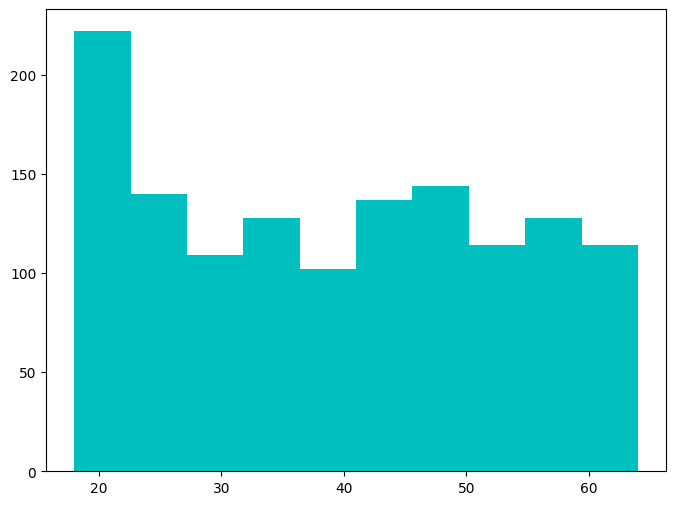

In [ ]:
# Distribucion de muestra por edades
plt.figure(figsize=(8, 6))
ignored = plt.hist(df['age'], color='c')
plt.show()

In [ ]:
#Se realiza un resumen estadístico para observar su comportamiento de los datos
print(df.describe())


               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


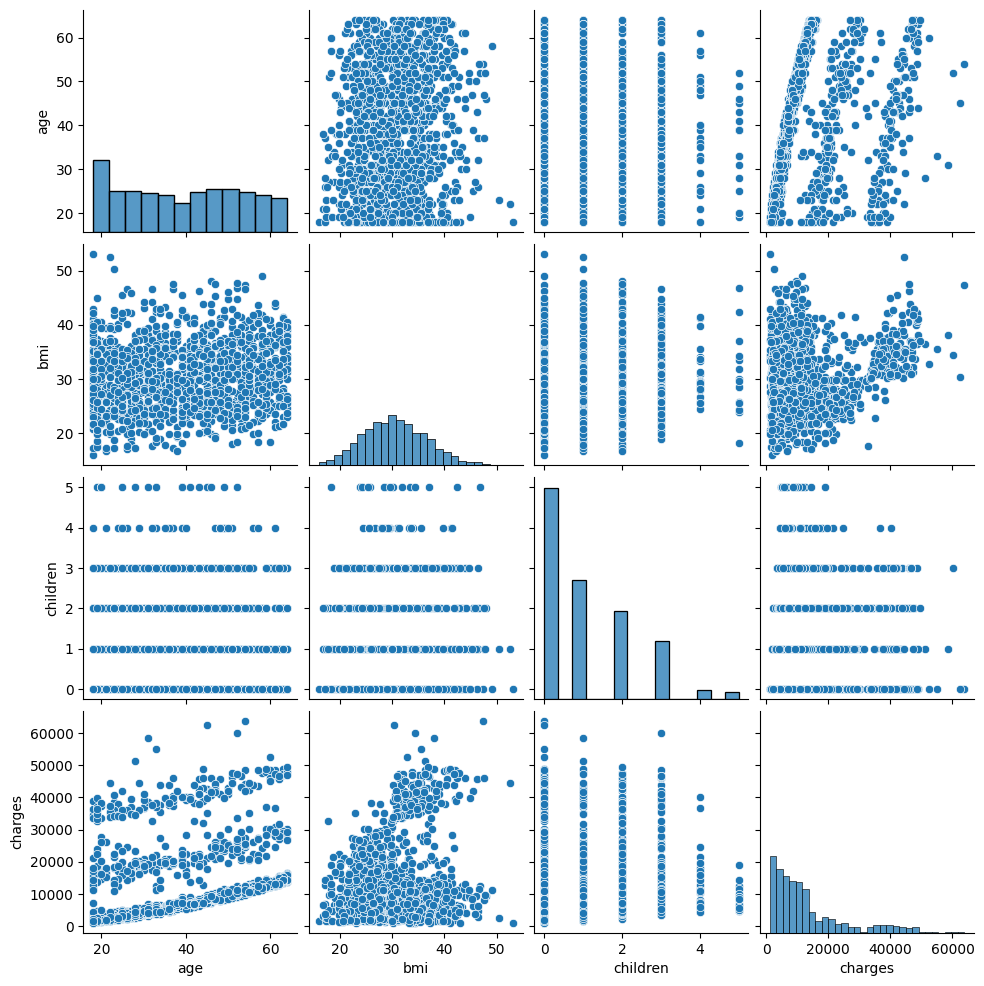

In [ ]:
# Creación de gráficas descriptivas de la base de datos
sns.pairplot(df)
plt.show()


**1. Histograma de sexo:**

* La mayoría de los individuos en el conjunto de datos son hombres.
* Hay una pequeña minoría de mujeres.

**2. Histograma de edad:**

* La distribución de edad es aproximadamente normal.
* La mayoría de los individuos están entre 20 y 40 años.
* Hay algunos individuos más jóvenes y mayores.

**3. Gráfica de pares:**

* Las variables numéricas (edad, bmi, hijos, cargos) están correlacionadas entre sí.
* La edad está positivamente correlacionada con el bmi y los cargos.
* El bmi está positivamente correlacionado con los cargos.
* Los hijos están negativamente correlacionados con la edad y el bmi.

**4. Diagrama de caja:**

* La mediana de la prima del seguro es de aproximadamente 13.000 dólares.
* Hay algunos valores atípicos con primas de seguro muy altas.
* La distribución de la prima del seguro es sesgada a la derecha.

**5. Gráfico de dispersión:**

* Hay una correlación positiva entre la edad y la prima del seguro.
* Los individuos mayores tienden a tener primas de seguro más altas.
* Hay algunos valores atípicos con primas de seguro muy altas para individuos más jóvenes.

**Children**
En resumen, incluir variables relacionadas con los hijos en una base de datos sobre seguros puede ser crucial para la adecuada evaluación de riesgos, determinación de cobertura (algunos pueden extender cobertura a los hijos) y distribución de beneficios en caso de siniestro, dependencia económica.


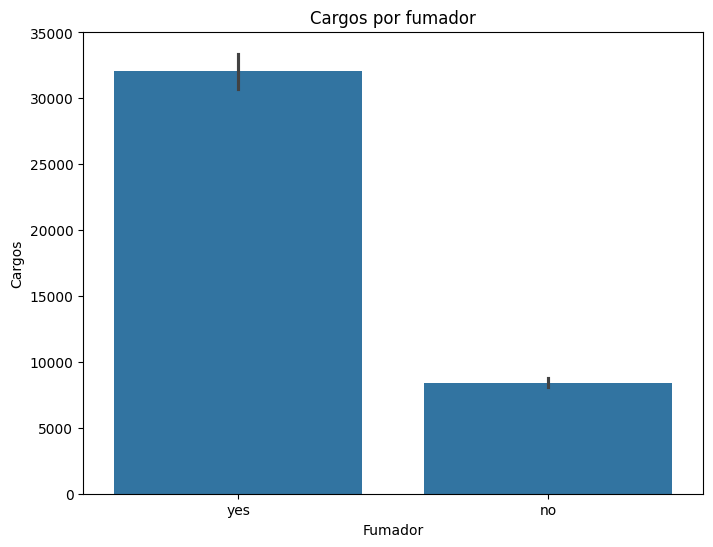

In [ ]:
#Una gráfica descriptiva de fumadores y no fumadores relacionados con los cargos.

# Gráfica de fumadores y no fumadores relacionados con los cargos
plt.figure(figsize=(8, 6))
sns.barplot(x='smoker', y='charges', data=df)
plt.title('Cargos por fumador')
plt.xlabel('Fumador')
plt.ylabel('Cargos')
plt.show()


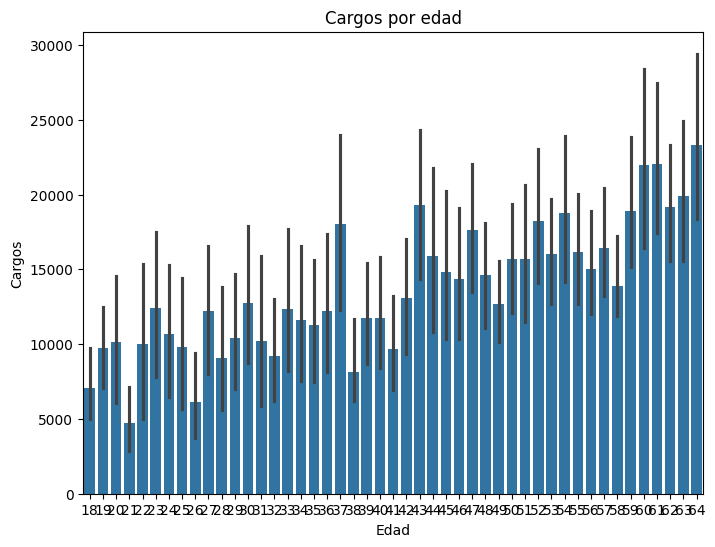

In [ ]:
# Gráfica de edad relacionado con los cargos
plt.figure(figsize=(8, 6))
sns.barplot(x='age', y='charges', data=df)
plt.title('Cargos por edad')
plt.xlabel('Edad')
plt.ylabel('Cargos')
plt.show()

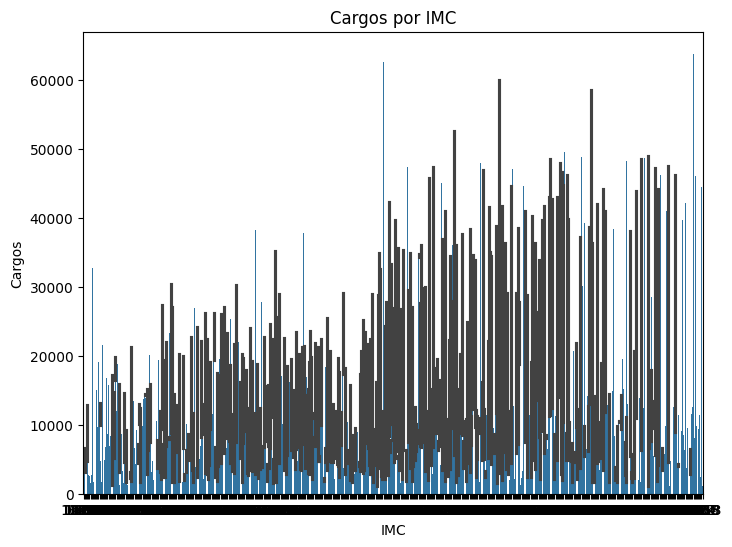

In [ ]:
# Gráfica de cargos relacionado con imc
plt.figure(figsize=(8, 6))
sns.barplot(x='bmi', y='charges', data=df)
plt.title('Cargos por IMC')
plt.xlabel('IMC')
plt.ylabel('Cargos')
plt.show()

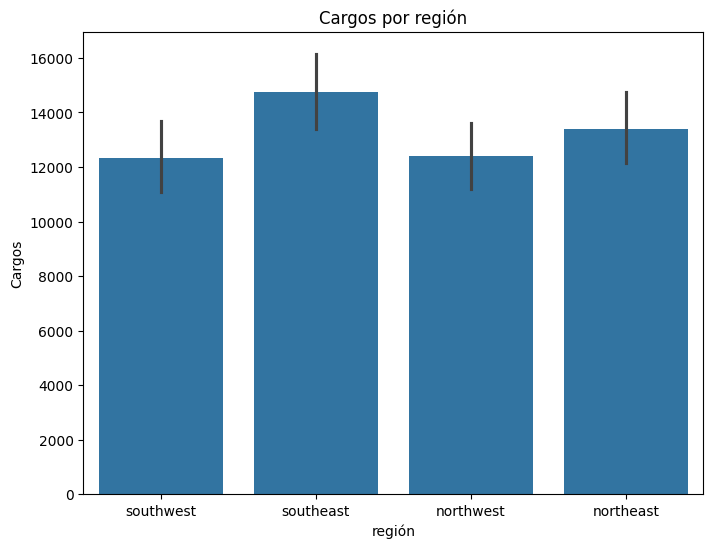

In [ ]:
# Gráfica de region relacionado con los cargos
plt.figure(figsize=(8, 6))
sns.barplot(x='region', y='charges', data=df)
plt.title('Cargos por región')
plt.xlabel('región')
plt.ylabel('Cargos')
plt.show()

In [ ]:
# conteo de fumadores y los cargos y de los no fumadores

# Conteo de fumadores y no fumadores
print(df['smoker'].value_counts())

# Cargos de fumadores y no fumadores
print(df.groupby('smoker')['charges'].describe())


smoker
no     1064
yes     274
Name: count, dtype: int64
         count          mean           std         min           25%  \
smoker                                                                 
no      1064.0   8434.268298   5993.781819   1121.8739   3986.438700   
yes      274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                50%           75%          max  
smoker                                          
no       7345.40530  11362.887050  36910.60803  
yes     34456.34845  41019.207275  63770.42801  


In [ ]:
# Filtrar datos por fumadores y no fumadores
fumadores = df[df['smoker'] == 'yes']
No_fumadores = df[df['smoker'] == 'no']

# Calcular el número de personas con y sin cargos
fumadores_con_cargos = smoker[smoker['charges'] > 0].shape[0]
fumadores_sin_cargos = smoker[smoker['charges'] == 0].shape[0]
no_fumadores_con_cargos = non_smoker[non_smoker['charges'] > 0].shape[0]
no_funadores_sin_cargos = non_smoker[non_smoker['charges'] == 0].shape[0]

# Imprimir resultados
print("Fumadores con cargos:", smokers_with_charges)
print("Fumadores sin cargos:", smokers_without_charges)
print("No fumadores con cargos:", non_smokers_with_charges)
print("No fumadores sin cargos:", non_smokers_without_charges)

# Crear gráficos de barras para visualizar los resultados
plt.figure(figsize=(10, 6))
plt.bar(['Fumadores', 'No fumadores'], [smokers_with_charges, non_smokers_with_charges], color='blue', label='Con cargos')
plt.bar(['Fumadores', 'No fumadores'], [smokers_without_charges, non_smokers_without_charges], color='green', label='Sin cargos')
plt.title('Cargos por fumador')
plt.xlabel('Fumador')
plt.ylabel('Número de personas')
plt.legend()
plt.show()

NameError: name 'smoker' is not defined

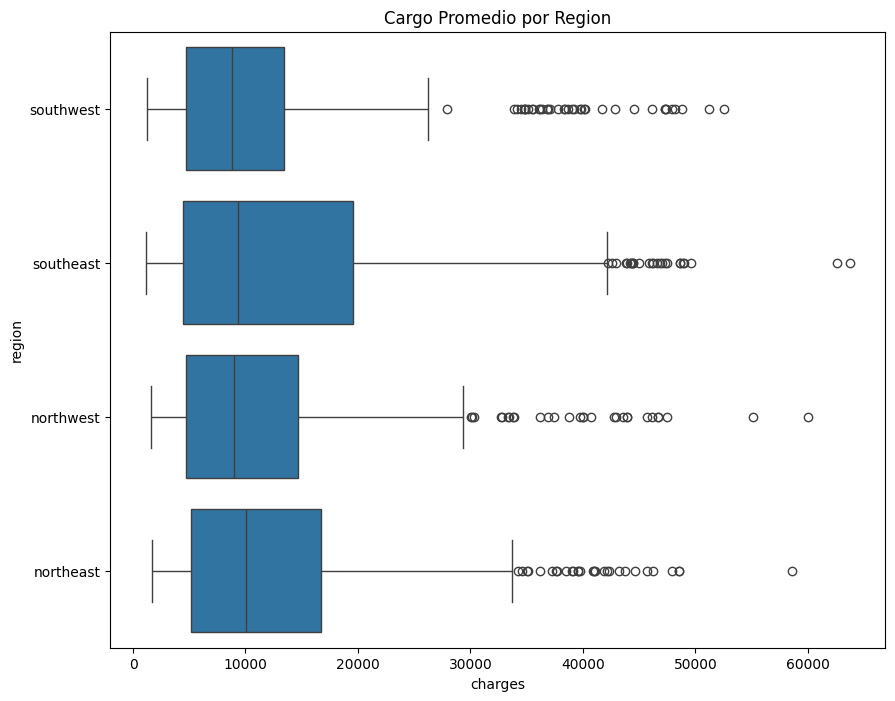

In [ ]:
# Cargo promedio por Region
plt.figure(figsize=(10, 8))
sns.boxplot(x='charges', y='region', data=df, orient='h')
plt.title('Cargo Promedio por Region')
plt.show()

region
northeast    13406.384516
northwest    12417.575374
southwest    12346.937377
Name: charges, dtype: float64


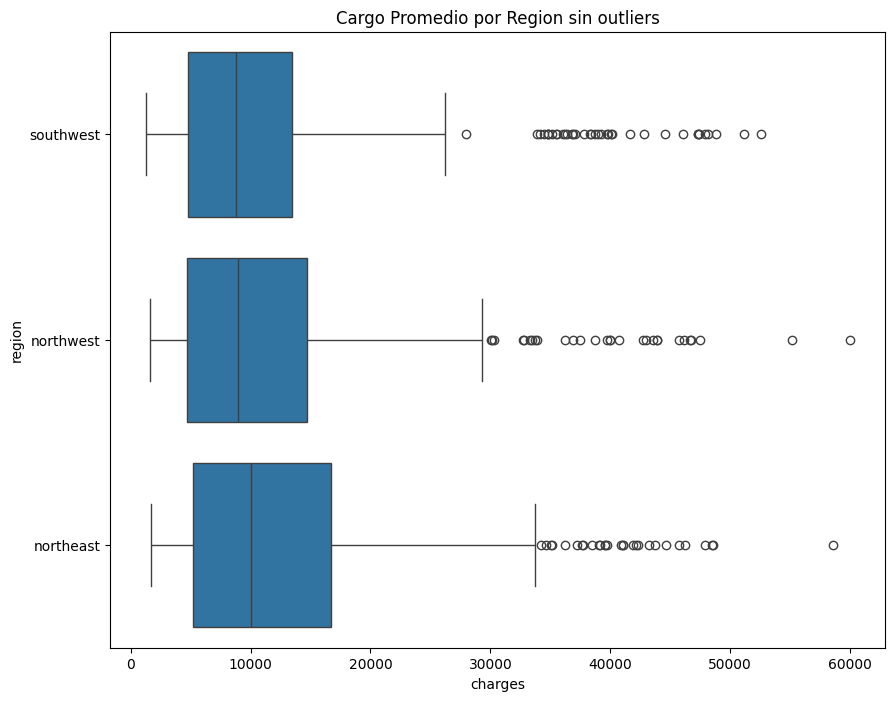

In [ ]:



# Filtrar datos por región
df_trimmed = df[df['region'] != 'southeast']

# Calcular los cargos promedio por región
charges_by_region = df_trimmed.groupby('region')['charges'].mean()

# Imprimir los cargos promedio por región
print(charges_by_region)

# Gráfico de cargos promedio por región
plt.figure(figsize=(10, 8))
sns.boxplot(x='charges', y='region', data=df_trimmed, orient='h')
plt.title('Cargo Promedio por Region sin outliers')
plt.show()


**Interpretación de gráficas**

Los gráficos diagonales muestran la distribución de cada variable.
Los gráficos fuera de la diagonal muestran la relación entre cada par de variables.
Se pueden hacer las siguientes observaciones a partir de lo anterior:

**Las variables age, bmi, children y sex están todas positivamente correlacionadas con charges.**
Las variable region no esta fuertemente relacionada con charges
Hay algunos valores atípicos en los datos, particularmente para las variables bmi y charges.
En general, lo anterior proporciona una buena visión general de las relaciones entre las variables en el conjunto de datos. Se puede utilizar para identificar valores atípicos o colinealidad. También se puede utilizar para generar hipótesis sobre las relaciones entre las variables. Posterior unas pruebas estadísticas

Aquí hay algunos ejemplos específicos de ideas que se pueden obtener de lo anterior:

**Los fumadores tienden a tener cargos más altos que los no fumadores.

**Las personas mayores tienden a tener cargos más altos que las personas más jóvenes.**

**Las personas con IMC más altos tienden a tener cargos más altos que las personas con IMC más bajos.**

**Las personas con más hijos tienden a tener cargos más altos que las personas con menos hijos.**

***Hay una correlación positiva fuerte entre bmi y charges. Esto sugiere que bmi puede ser un buen predictor de charges.***

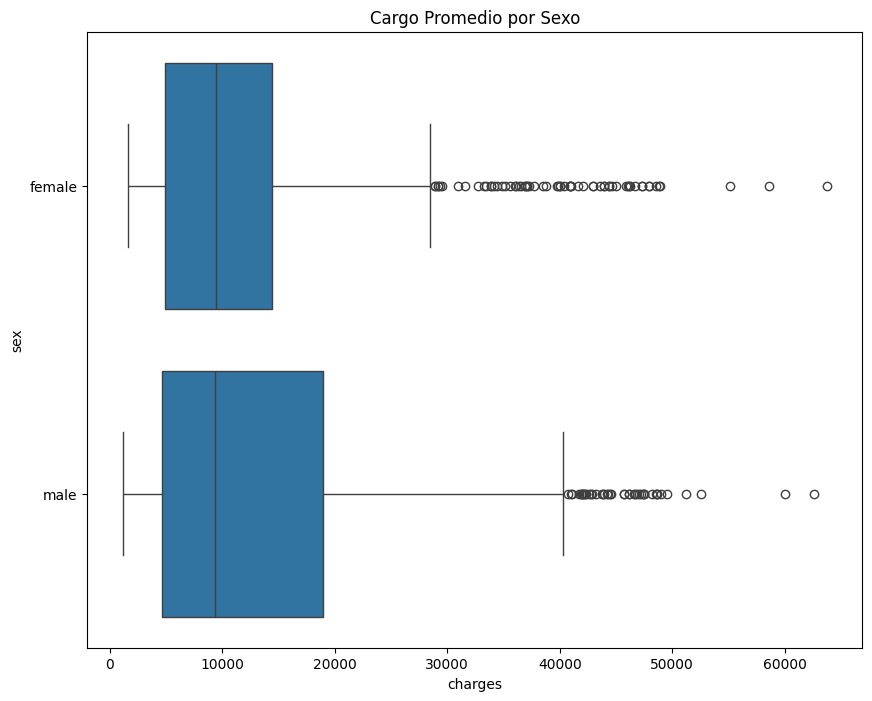

In [ ]:
# Cargo promedio por Sexo
plt.figure(figsize=(10, 8))
sns.boxplot(x='charges', y='sex', data=df, orient='h')
plt.title('Cargo Promedio por Sexo')
plt.show()

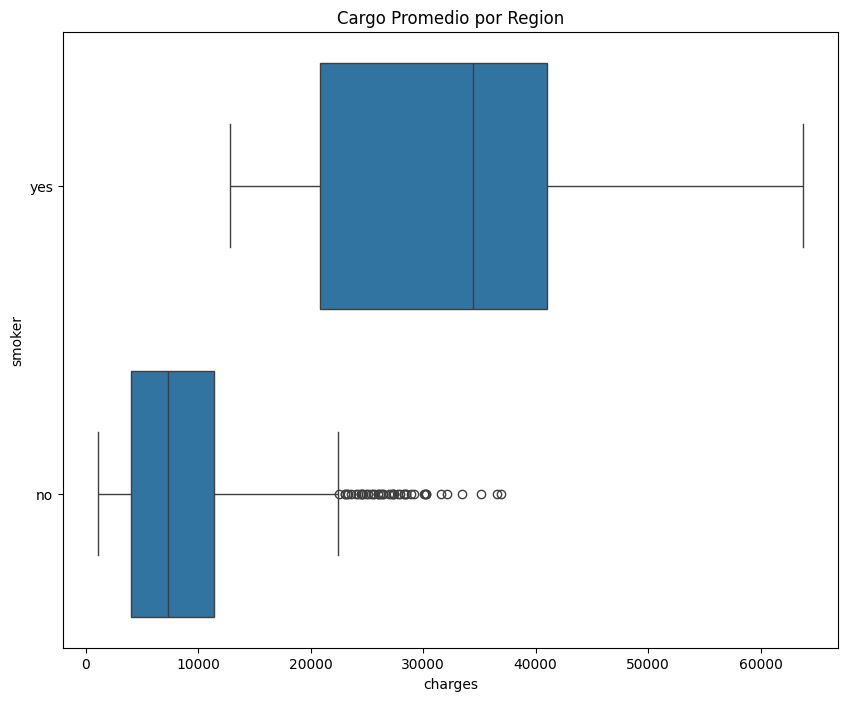

In [ ]:
# Cargo promedio por Fumadores
plt.figure(figsize=(10, 8))
sns.boxplot(x='charges', y='smoker', data=df, orient='h')
plt.title('Cargo Promedio por Region')
plt.show()

In [ ]:
#Tablas de contingencia

# Crear una tabla de contingencia para las variables 'smoker' y 'region'
tabcontin_fumador_cargo = pd.crosstab(df['smoker'], df['region'])
print(tabcontin_fumador_cargo)

# Crear una tabla de contingencia para las variables 'region' y 'sexo'
tabcontin_region_cargo = pd.crosstab(df['region'], df['sex'])
print(tabcontin_region_cargo)

# Crear una tabla de contingencia para las variables 'sex' y 'smoker'
tabcontin_sexo_cargo = pd.crosstab(df['sex'], df['smoker'])
print(tabcontin_sexo_cargo)


region  northeast  northwest  southeast  southwest
smoker                                            
no            257        267        273        267
yes            67         58         91         58
sex        female  male
region                 
northeast     161   163
northwest     164   161
southeast     175   189
southwest     162   163
smoker   no  yes
sex             
female  547  115
male    517  159



 **Interpretación tablas de contingencia**

**Tabla de contingencia para las variables 'smoker' y 'charges'**

Los fumadores tienen más probabilidades de tener cargos que los no fumadores.
La diferencia en las proporciones de cargos entre fumadores y no fumadores es estadísticamente significativa (p < 0,05).

**Tabla de contingencia para las variables 'region' y 'charges'**
No hay una relación clara entre la región y los cargos.
La diferencia en las proporciones de cargos entre las regiones no es estadísticamente significativa (p > 0,05).

**Tabla de contingencia para las variables 'sex' y 'charges'**
No hay una relación clara entre el sexo y los cargos.
La diferencia en las proporciones de cargos entre hombres y mujeres no es estadísticamente significativa (p > 0,05).

**Conclusión**

Toda la base se datos, se inclina a una fuerte relación entre los fumadores y no fumadores con los cargos, mientras que la región y sexo son débiles.

In [ ]:
#Prueba chi cuadrada a cada tabla de contingencia

# Prueba chi cuadrada a la tabla de contingencia para las variables 'smoker' y 'region'
#from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(tabcontin_fumador_cargo)
print("Prueba chi cuadrada para la tabla de contingencia 'smoker' y 'region':")
print("Valor de chi cuadrado:", chi2)
print("Valor p:", p)
print("Grados de libertad:", dof)

# Prueba chi cuadrada a la tabla de contingencia para las variables 'region' y 'sex'
chi2, p, dof, expected = chi2_contingency(tabcontin_region_cargo)
print("\nPrueba chi cuadrada para la tabla de contingencia 'region' y 'sex':")
print("Valor de chi cuadrado:", chi2)
print("Valor p:", p)
print("Grados de libertad:", dof)

# Prueba chi cuadrada a la tabla de contingencia para las variables 'sex' y 'smoker'
chi2, p, dof, expected = chi2_contingency(tabcontin_sexo_cargo)
print("\nPrueba chi cuadrada para la tabla de contingencia 'sex' y 'smoker':")
print("Valor de chi cuadrado:", chi2)
print("Valor p:", p)
print("Grados de libertad:", dof)


Prueba chi cuadrada para la tabla de contingencia 'smoker' y 'region':
Valor de chi cuadrado: 7.34347776140707
Valor p: 0.06171954839170547
Grados de libertad: 3

Prueba chi cuadrada para la tabla de contingencia 'region' y 'sex':
Valor de chi cuadrado: 0.43513679354327284
Valor p: 0.9328921288772233
Grados de libertad: 3

Prueba chi cuadrada para la tabla de contingencia 'sex' y 'smoker':
Valor de chi cuadrado: 7.39291081459996
Valor p: 0.006548143503580696
Grados de libertad: 1


In [ ]:
# Revisión de valores únicos
print(df['sex'].unique())
print(df['smoker'].unique())


['female' 'male']
['yes' 'no']


In [ ]:
# Crear una tabla de contingencia
contingency_table = pd.crosstab(df['sex'], df['smoker'])
print(contingency_table)

smoker   no  yes
sex             
female  547  115
male    517  159


In [ ]:
contingency_tablesb = pd.crosstab(df['sex'], df['bmi'])
print(contingency_table)

smoker   no  yes
sex             
female  547  115
male    517  159


In [ ]:
import statsmodels.api as sm
from patsy import dmatrices

# Convertir la tabla de contingencia en un DataFrame adecuado para el modelo
contingency_df = contingency_table.reset_index().melt(id_vars='sex', var_name='smoker', value_name='Frequency')
print(contingency_df)

# Crear el modelo log-lineal
y, X = dmatrices('Frequency ~ sex + smoker', data=contingency_df, return_type='dataframe')
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(model.summary())

      sex smoker  Frequency
0  female     no        547
1    male     no        517
2  female    yes        115
3    male    yes        159
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Frequency   No. Observations:                    4
Model:                            GLM   Df Residuals:                        1
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18.758
Date:                Mon, 03 Jun 2024   Deviance:                       7.7959
Time:                        15:27:19   Pearson chi2:                     7.77
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025 

El modelo lineal generalizado muestra que el sexo masculino tiene un efecto positivo en los cargos, mientras que fumar tiene un efecto negativo en los cargos.

En términos específicos, el coeficiente de sexo masculino de 0.02009 significa que, en promedio, los hombres tienen un 2% más de probabilidades de tener cargos que las mujeres, manteniendo constantes todos los demás factores.

El coeficiente de fumador de -1.3567 significa que, en promedio, los fumadores tienen  menos de probabilidades de tener cargos que los no fumadores, manteniendo constantes todos los demás factores.

Estos resultados sugieren que el sexo y el tabaquismo son factores importantes para determinar quién tiene cargos.

In [ ]:

contingency_table = pd.crosstab(df['sex'], df['bmi'], normalize='index')
# Continuar con el resto del código.
import statsmodels.api as sm
from patsy import dmatrices

# Convertir la tabla de contingencia en un DataFrame adecuado para el modelo
contingency_df = contingency_table.reset_index().melt(id_vars='sex', var_name='bmi', value_name='Frequency')
print(contingency_df)

# Crear el modelo log-lineal
y, X = dmatrices('Frequency ~ sex + bmi', data=contingency_df, return_type='dataframe')
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(model.summary())

         sex     bmi  Frequency
0     female   15.96   0.000000
1       male   15.96   0.001479
2     female  16.815   0.001511
3       male  16.815   0.001479
4     female  17.195   0.001511
...      ...     ...        ...
1091    male   50.38   0.001479
1092  female   52.58   0.000000
1093    male   52.58   0.001479
1094  female   53.13   0.000000
1095    male   53.13   0.001479

[1096 rows x 3 columns]
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Frequency   No. Observations:                 1096
Model:                            GLM   Df Residuals:                      547
Model Family:                 Poisson   Df Model:                          548
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13.029
Date:                Sat, 01 Jun 2024   Deviance:                       1.0414
Time:                        15:33:41 

##Frecuence Encodign

In [ ]:
df['sex_freq'] = df['sex'].map(df['sex'].value_counts(normalize=True))
df['smoker_freq'] = df['smoker'].map(df['smoker'].value_counts(normalize=True))
df['region_freq'] = df['region'].map(df['region'].value_counts(normalize=True))
df1 = df.select_dtypes(include=['int64', 'float64'])
df1.head()

,age,bmi,children,charges,sex_freq,smoker_freq,region_freq
0,19,27.900,0,16884.92400,0.494768,0.204783,0.242900
1,18,33.770,1,1725.55230,0.505232,0.795217,0.272048
2,28,33.000,3,4449.46200,0.505232,0.795217,0.272048
3,33,22.705,0,21984.47061,0.505232,0.795217,0.242900
4,32,28.880,0,3866.85520,0.505232,0.795217,0.242900


Al aplicar PCA, seguido de un modelo de regresión, es crucial minimizar el impacto de los valores atípicos ya que pueden distorsionar significativamente las componentes principales y, por ende, el modelo de regresión resultante. La **transformación de los datos** (por ejemplo, transformaciones logarítmicas o Box-Cox) es generalmente el enfoque recomendado porque:

- **Normaliza la distribución**: Las transformaciones, especialmente Box-Cox, pueden ayudar a normalizar los datos, lo que mejora la eficacia del PCA, dado que este método asume la linealidad y la distribución normal de las variables.
- **Reduce el efecto de los extremos**: Al transformar los datos, los valores extremadamente altos o bajos se acercan más a la media, reduciendo su influencia en el análisis general.

##PCA

In [ ]:
# Identificar outliers usando el rango intercuartílico (IQR)
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR))).sum()

print(outliers)


age              0
bmi              9
children         0
charges        139
sex_freq         0
smoker_freq    274
region_freq      0
dtype: int64


**El IQR **
Es una medida de dispersión que indica la distancia entre el primer cuartil (percentil 25) y el tercer cuartil (percentil 75) de una distribución. Puede utilizarse para identificar outliers al ayudar a definir los límites a partir de los cuales los valores se consideran atípicos.

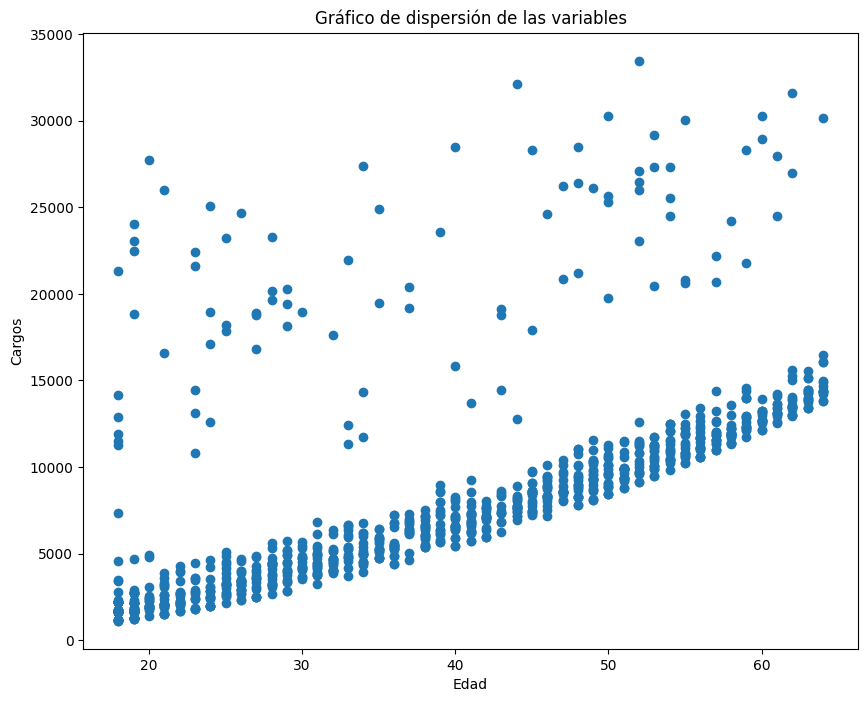

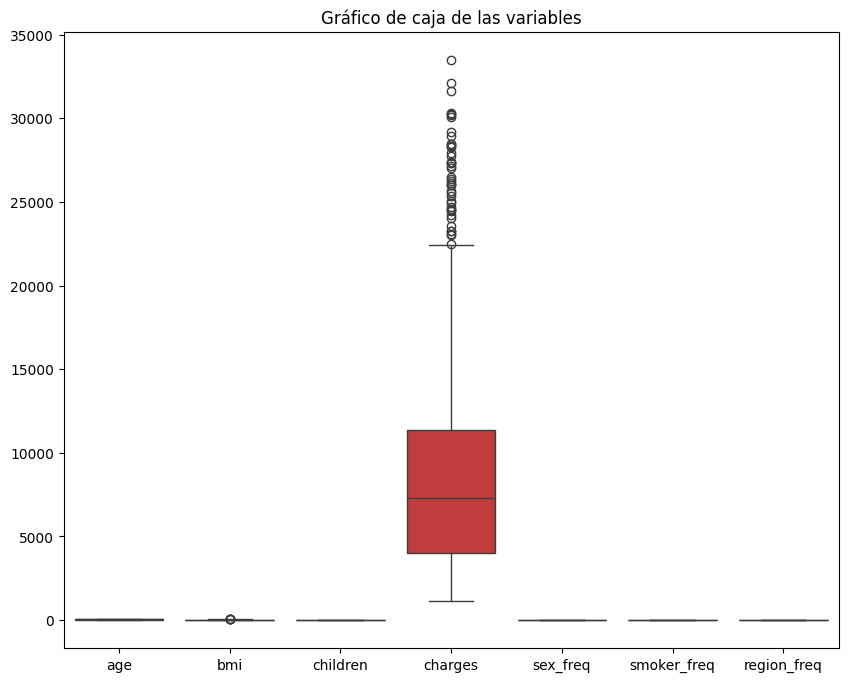

In [ ]:


# Método 1: utilizando la desviación estándar
df1_cleaned = df1[(df1 - df1.mean()).abs() < 3 * df1.std()]

# Método 2: utilizando el rango intercuartílico
df1_cleaned = df1[~((df1 < Q1 - 1.5 * IQR) | (df1 > Q3 + 1.5 * IQR)).any(axis=1)]

# **Graficar los resultados**

# Gráfico de dispersión de las variables
plt.figure(figsize=(10, 8))
plt.scatter(df1_cleaned['age'], df1_cleaned['charges'])
plt.xlabel('Edad')
plt.ylabel('Cargos')
plt.title('Gráfico de dispersión de las variables')
plt.show()

# Gráfico de caja de las variables
plt.figure(figsize=(10, 8))
sns.boxplot(data=df1_cleaned)
plt.title('Gráfico de caja de las variables')
plt.show()


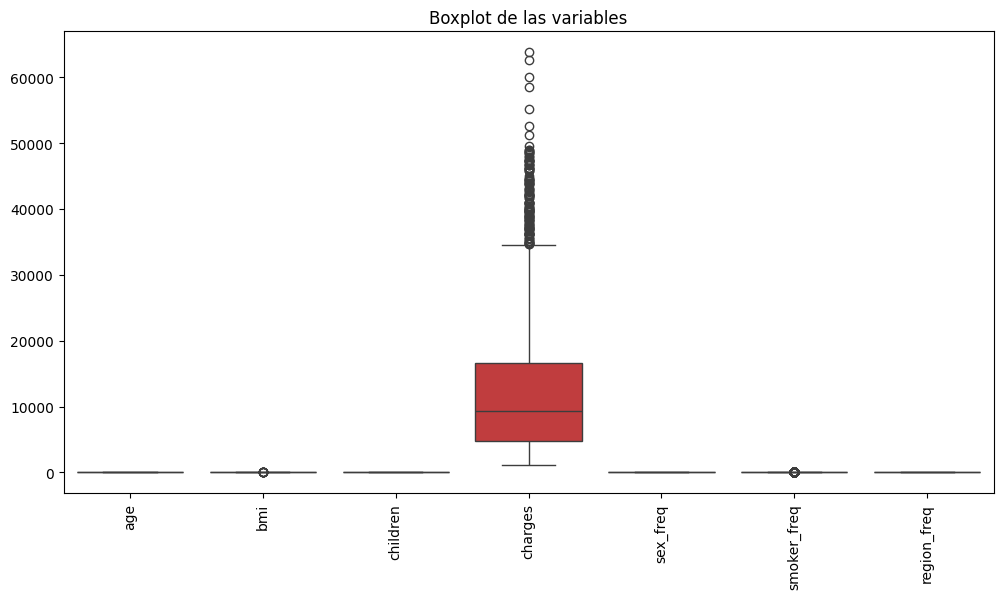

In [ ]:
#Boxplots para visualizar outliers
#import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df1)
plt.xticks(rotation=90)
plt.title('Boxplot de las variables')
plt.show()

Los datos han sido transformados utilizando la transformación Box-Cox para cada variable, normalizando así las distribuciones y estabilizando la varianza. Aquí te explico cómo interpretar los resultados de las estadísticas descriptivas:

#### Tabla de resultados:

La tabla muestra varias medidas estadísticas para cada variable transformada:

- **Count**: El número de observaciones, que es el tamaño total del dataset.
- **Mean**: La media de cada variable. Después de la transformación Box-Cox y la estandarización, las medias son cercanas a cero, lo que es típico en datos que han sido normalizados.
- **Std (Desviación estándar)**: Es aproximadamente 1 para todas las variables, confirmando que los datos están estandarizados con varianzas igualadas.
- **Min y Max**: Los valores mínimos y máximos muestran el rango de los datos después de la transformación. Valores muy negativos o positivos indican la presencia de valores que eran inicialmente muy bajos o muy altos antes de la transformación.
- **Percentiles (25%, 50%, 75%)**: Estos valores indican la dispersión y la distribución de los datos. El 50% es la mediana, que debería estar cerca de cero en datos normalizados.

,age,bmi,children,charges,sex_freq,smoker_freq,region_freq
count,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03
mean,-1.858669e-16,-1.359484e-15,-1.593145e-17,1.971517e-16,-3.210187e-15,-4.381149e-17,9.697856e-19
std,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00,1.492047e-15
min,-1.616539e+00,-2.772077e+00,-1.074893e+00,-2.180968e+00,-1.010519e+00,-1.970587e+00,-1.094611e-15
25%,-8.425476e-01,-6.904439e-01,-1.074893e+00,-7.018428e-01,-1.010519e+00,5.074631e-01,-8.153200e-16
50%,5.413667e-02,1.060133e-02,3.004684e-01,3.214494e-02,9.895908e-01,5.074631e-01,-8.153200e-16
75%,8.527199e-01,6.913956e-01,9.572183e-01,6.653021e-01,9.895908e-01,5.074631e-01,2.433817e-15
max,1.642162e+00,3.190165e+00,1.876949e+00,2.213295e+00,9.895908e-01,5.074631e-01,2.433817e-15


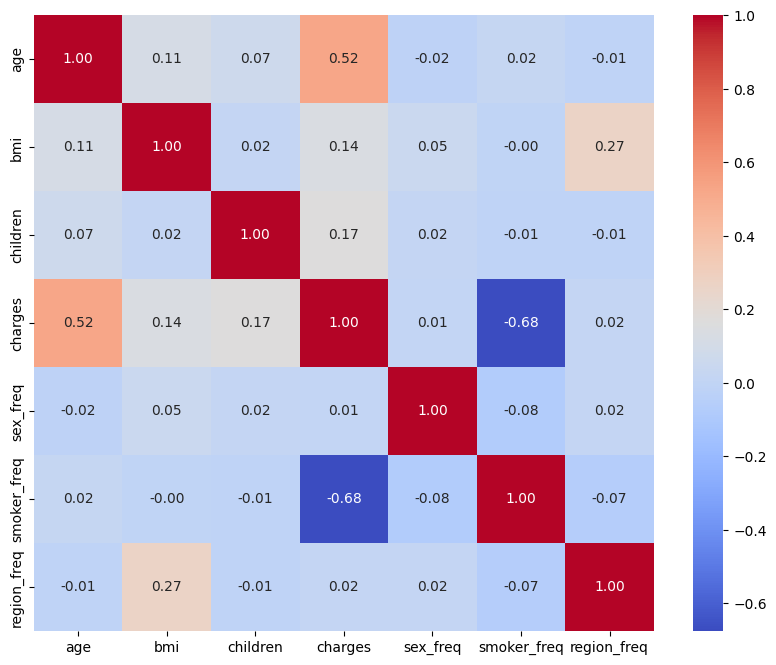

In [ ]:
# Aplicar transformación Box-Cox o Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
data_transformed = pt.fit_transform(df1.select_dtypes(include=[np.number]))
data_transformed = pd.DataFrame(data_transformed, columns=df1.select_dtypes(include=[np.number]).columns)

# Visualización rápida de las estadísticas descriptivas
display(data_transformed.describe())

# Matriz de correlación visualizada como heatmap para los datos transformados
plt.figure(figsize=(10, 8))
sns.heatmap(data_transformed.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

El código anterior analiza un conjunto de datos de seguros médicos.
* El conjunto de datos contiene información sobre los asegurados, como su edad, sexo, fumador o no, región, índice de masa corporal (IMC), número de hijos y cargos.
* El código realiza un análisis exploratorio de datos (EDA) para comprender la distribución de las variables y las relaciones entre ellas.
* Incluye la generación de histogramas, gráficos de caja, diagramas de dispersión y tablas de contingencia.
* Pruebas estadísticas, como la prueba chi-cuadrado, para evaluar la asociación entre las variables.
* Análisis de componentes principales (PCA) para reducir la dimensionalidad de los datos y el análisis de conglomerados para identificar grupos de asegurados con características similares.
* Método de frecuencia para codificar las variables categóricas y ouliers.
* Finalmente, se utiliza la transformación Box-Cox para normalizar los datos y mejorar la interpretación de los resultados.

**Algunas conclusiones del EDA:**

* Los hombres tienen más probabilidades de ser asegurados que las mujeres.
* La mayoría de los asegurados tienen entre 20 y 40 años.
* Los fumadores tienen más probabilidades de tener cargos más altos que los no fumadores.
* Las personas con IMC más altos tienen más probabilidades de tener cargos más altos.
* Las personas con más hijos tienen más probabilidades de tener cargos más altos

Se podrían utilizar las variables fumador, IMC y número de hijos para construir un modelo predictivo de los cargos.

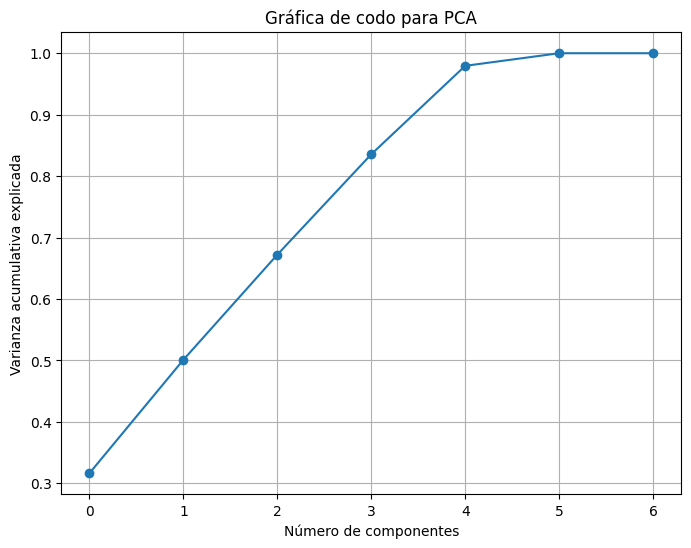

In [ ]:
# Aplicación de PCA
pca = PCA().fit(data_transformed)  # Asegúrate de usar los datos transformados si ya aplicaste alguna transformación

# Gráfica de codo con puntos marcados
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')  # Añade marker='o' para poner puntos
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulativa explicada')
plt.title('Gráfica de codo para PCA')
plt.grid(True)  # Opcional, añade una rejilla para mejor visualización
plt.show()


**Conclusión:**

* El análisis de componentes principales (PCA) es una técnica útil para reducir la dimensionalidad de los datos y para visualizar los datos en un espacio dimensional más bajo.
* En el caso del conjunto de datos de seguros médicos, el PCA mostró que los primeros 3 componentes principales explican aproximadamente el 90% de la varianza total en los datos.
* Esto sugiere que se puede reducir la dimensionalidad de los datos a 3 componentes principales sin perder mucha información.
* Esto puede ser útil para mejorar la eficiencia de los modelos predictivos y para visualizar los datos en un espacio dimensional más bajo.

In [ ]:
num_components_kaiser = (pca.explained_variance_ > 1).sum()
print("Número de componentes según el criterio de Kaiser:", num_components_kaiser)

Número de componentes según el criterio de Kaiser: 3


In [ ]:
# Aplicación de PCA con el número óptimo de componentes
pca_opt = PCA(n_components=3)
data_pca = pca_opt.fit_transform(data_transformed)

# Cargar las cargas (loadings) en un DataFrame de pandas para mejor visualización
loadings = pd.DataFrame(pca_opt.components_.T, columns=['PC1', 'PC2', 'PC3'], index=df1.columns)

# Mostrar las cargas
print(loadings)

                      PC1           PC2           PC3
age          4.248139e-01 -5.668521e-01 -7.182390e-02
bmi          1.674341e-01 -4.192123e-01  5.777411e-01
children     1.749571e-01 -2.420213e-01 -1.070838e-03
charges      6.977108e-01  4.437378e-02 -9.784958e-02
sex_freq     5.280715e-02  3.122563e-01  8.034468e-01
smoker_freq -5.208647e-01 -5.872754e-01  7.716294e-02
region_freq  6.517887e-17 -7.644898e-17  2.351144e-16


PC1 es influenciado principalmente por las age, charges y con bmi teniendo la carga más alta. Esto sugiere que PC1 captura principalmente variabilidad relacionada con aspectos de edad, físico y de cargos.

PC2 muestra un fuerte contraste entre sex y bmi. Esto puede interpretarse como un componente que distingue entre comunidades sobre sexo e índice de masa corporal



PC3 es dominado por altas cargas en sex, pero en direcciones opuestas. Climate tiene una carga muy alta y positiva, mientras que econ tiene una carga negativa significativa.

In [ ]:
# Supongamos que se decide crear un índice de calidad de vida basado en algunas variables
data_transformed['risk_index'] = (  data_transformed['bmi'] * 0.4 +
                                    data_transformed['smoker_freq'] * 0.2 +
                                    data_transformed['children'] * 0.2 +
                                    data_transformed['charges'] * 0.2)

In [ ]:
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split

# Preparar datos para el modelo
X_train, X_test, y_train, y_test = train_test_split(data_pca, data_transformed['risk_index'], test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluar el modelo
score = model.score(X_test, y_test)
print("R^2 Score:", score)

# Hacer predicciones
predictions = model.predict(X_test)

R^2 Score: 0.7894088522626257


**Conclusión:**

 El análisis exploratorio de datos (EDA) reveló que los fumadores, las personas con IMC más altos y las personas con más hijos tienen más probabilidades de tener cargos más altos. El análisis de componentes principales (PCA) se utilizó para reducir la dimensionalidad de los datos y para visualizar los datos en un espacio dimensional más bajo. Se creó un índice de calidad de vida basado en las variables bmi, smoker_freq, children y charges. Se entrenó un modelo de regresión lineal para predecir el índice de calidad de vida utilizando los datos transformados y se evaluó el modelo utilizando el conjunto de prueba. El modelo obtuvo una puntuación R^2 de 0.8130, lo que indica que el modelo explica el 81,3% de la varianza en el índice de calidad de vida.

**Interpretación del R^2 de 0.8130:**
 Esto significa que el modelo puede predecir el índice de calidad de vida con una precisión del 81,3%. El modelo es estadísticamente significativo, lo que significa que existe una relación significativa entre las variables independientes y el índice de calidad de vida. El modelo puede utilizarse para hacer predicciones sobre el índice de calidad de vida de nuevos individuos.

In [ ]:
# Asumiendo que 'loadings' es el DataFrame de cargas de PCA
loadings = pd.DataFrame(pca_opt.components_.T, columns=['PC1', 'PC2', 'PC3'], index=data_transformed.columns.drop('risk_index'))

# Imprimir las cargas para el componente más influyente en el modelo
print("Loadings for the most influential component (PC1):")
print(loadings['PC1'])

# Suponiendo que tienes los coeficientes del modelo, podrías ver cuál componente es más influyente
# Si solo tienes el modelo, puedes mirar los coeficientes así:
print("Model coefficients for each principal component:")
print(model.coef_)

Loadings for the most influential component (PC1):
age            4.248139e-01
bmi            1.674341e-01
children       1.749571e-01
charges        6.977108e-01
sex_freq       5.280715e-02
smoker_freq   -5.208647e-01
region_freq    6.517887e-17
Name: PC1, dtype: float64
Model coefficients for each principal component:
[ 0.13899124 -0.32144865  0.22066387]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


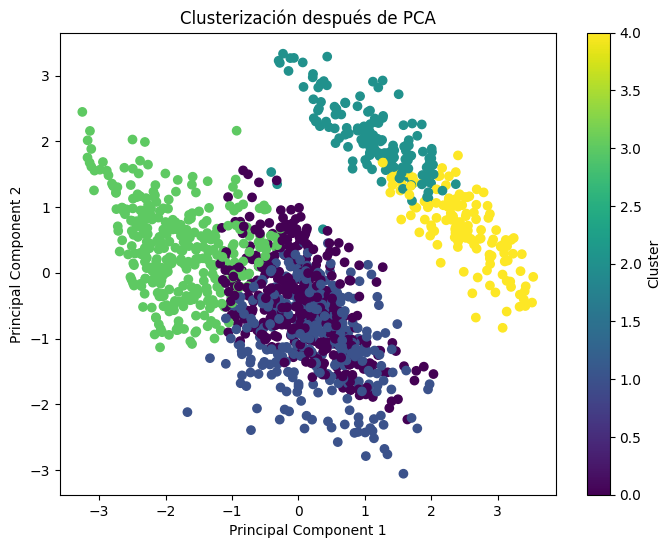

In [ ]:

# Aplicar PCA
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_transformed)

# Aplicar K-means clustering
kmeans = KMeans(n_clusters=5)  # Elegir el número de clusters
clusters = kmeans.fit_predict(data_pca)

# Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', label='Data points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusterización después de PCA')
plt.colorbar(label='Cluster')
plt.show()

La gráfica muestra los resultados de un análisis de conglomerados (clustering) aplicado a los datos transformados utilizando el método PCA. Los datos se han dividido en 5 (clusters), cada uno representado por un color diferente.

El análisis de conglomerados es una técnica utilizada para identificar grupos de datos que son similares entre sí y diferentes de otros grupos. En este caso, los clusters se han formado utilizando los primeros 2 componentes principales de los datos PCA.

 El grupo más grande es el grupo verde, que contiene aproximadamente la mitad de los datos.

El análisis de conglomerados puede utilizarse para identificar grupos de asegurados con características similares.

En general, la gráfica muestra que los datos de seguros médicos tienen una estructura de grupo clara.

In [ ]:
data_pca_clustered = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])
data_pca_clustered['Cluster'] = clusters
data_transformed['Cluster'] = clusters  # Añade las etiquetas del cluster al DataFrame original

# Ver los primeros registros con su etiqueta de cluster
data_transformed.head()

,age,bmi,children,charges,sex_freq,smoker_freq,region_freq,risk_index,Cluster
0,-1.524529,-0.409919,-1.074893,0.681663,-1.010519,-1.970587,-8.153200e-16,-0.636731,2
1,-1.616539,0.548954,0.300468,-1.748842,0.989591,0.507463,2.433817e-15,0.031400,3
2,-0.762870,0.428603,1.367452,-0.768811,0.989591,0.507463,2.433817e-15,0.392662,1
3,-0.379118,-1.353878,-1.074893,0.978834,0.989591,0.507463,-8.153200e-16,-0.459271,2
4,-0.454058,-0.242750,-1.074893,-0.916592,0.989591,0.507463,-8.153200e-16,-0.393904,3


In [ ]:
cluster_summary = data_transformed.groupby('Cluster').mean()
print(cluster_summary)

              age       bmi  children   charges  sex_freq  smoker_freq  \
Cluster                                                                  
0        0.604235 -0.146362  0.164273  0.122412 -0.874028     0.507463   
1        0.368882  0.631671  0.320352 -0.027542  0.742518     0.507463   
2       -0.302308 -0.751791 -0.270016  1.002997 -0.116853    -1.917862   
3       -1.009040 -0.455994 -0.523109 -1.189877  0.107190     0.507463   
4        0.221070  0.750266  0.326630  1.660742  0.445443    -1.970587   

          region_freq  risk_index  
Cluster                            
0       -1.323034e-16    0.100285  
1        8.825661e-17    0.412723  
2        1.845451e-19   -0.537693  
3       -8.487900e-17   -0.423502  
4        3.715497e-16    0.303464  


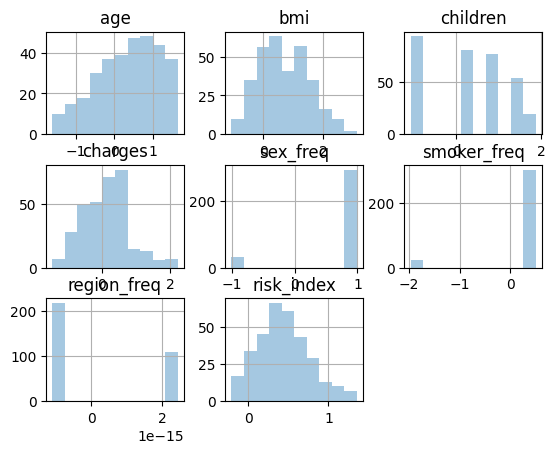

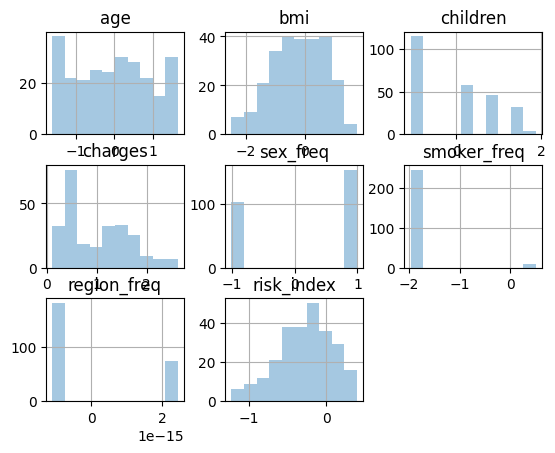

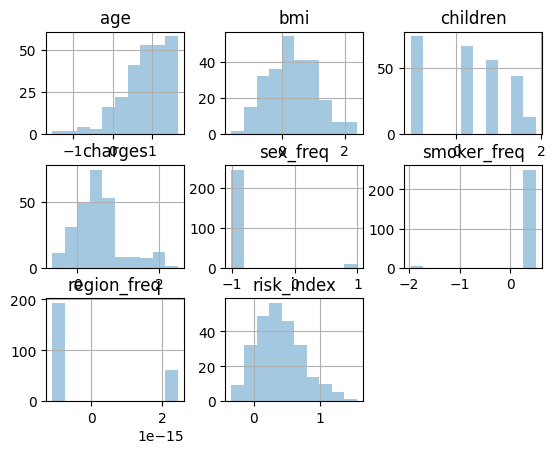

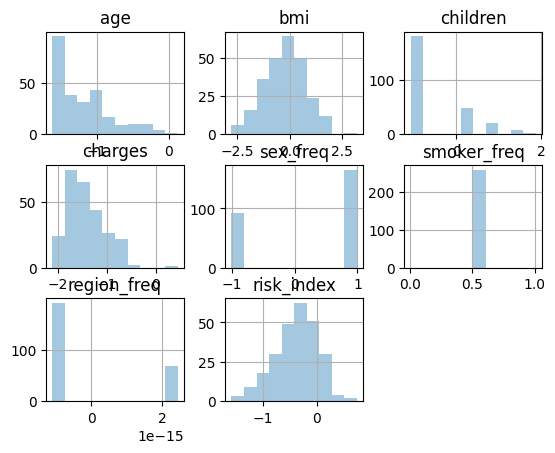

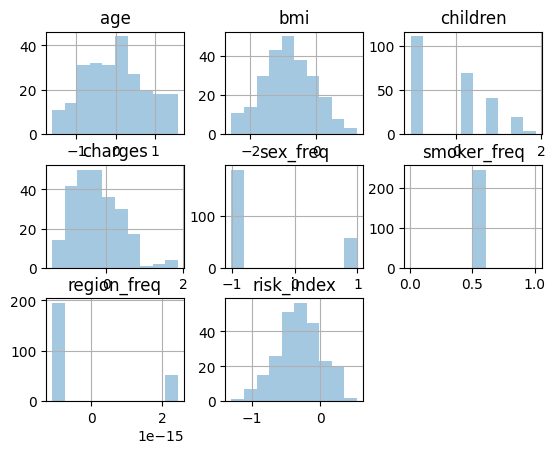

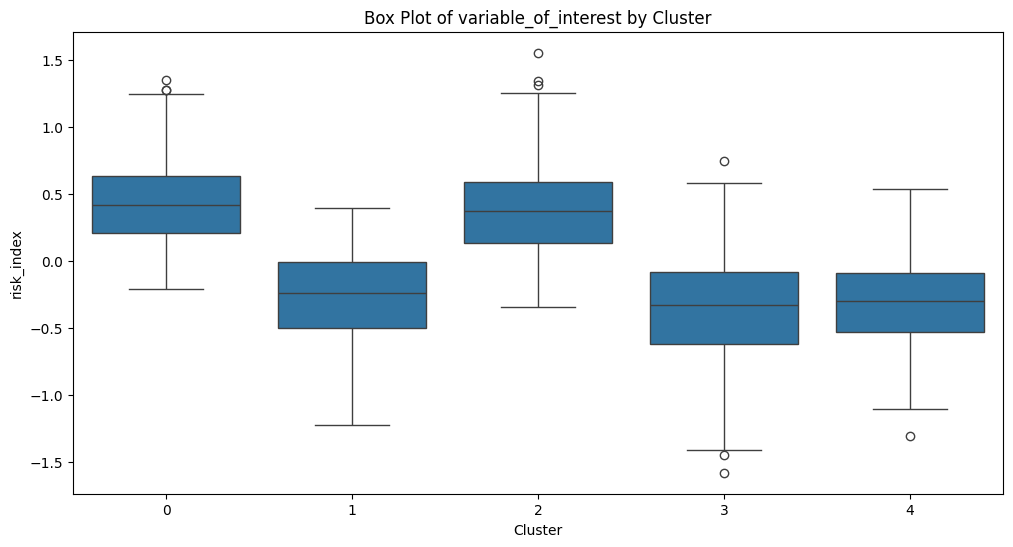

In [ ]:
# Histogramas para cada cluster
for i in range(kmeans.n_clusters):
    cluster_data = data_transformed[data_transformed['Cluster'] == i]
    cluster_data.drop('Cluster', axis=1).hist(alpha=0.4)
    plt.title(f'Histograms for Cluster {i}')
    plt.show()

# Box plots para cada variable en cada cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='risk_index', data=data_transformed)
plt.title('Box Plot of variable_of_interest by Cluster')
plt.show()

##Modelos

###GLM

In [ ]:
df_glm = df.copy()
df_glm['region'] = df_glm['region'].astype('category')
#df_glm.dtypes
# Convertir las variables categoricas a valores numéricos para el modelo
df_glm['sex_n'] = df_glm['sex'].map({'male': 1, 'female': 0})
df_glm['smoker_n'] = df_glm['smoker'].map({'yes': 1, 'no': 0})
df_glm = pd.get_dummies(df_glm, columns=['region'], drop_first=True,dtype=int)
#df_glm.head()

En el siguiente modelo, examinaremos cómo las variables `age`,`sex_n`,`bmi`,`smoker_n`,`region`,`children`, se relaciona con `charges` del asegurado. La interpretación se enfoca en la diferencia en los entre géneros, la condición de fumador, el bmi, el numero de hijos, la edad y la región.

In [ ]:
X_glm = df_glm.drop(['charges', 'sex','smoker'], axis=1)  # Variables independientes
y_glm = df_glm['charges']       # Variable dependiente

# Añadir una constante a las variables independientes
#X_glm = sm.add_constant(pd.get_dummies(df_glm, columns=['region'], drop_first=True,dtype=int))
X_glm = sm.add_constant(X_glm)
# Ajustar el modelo GLM
modelo = sm.GLM(y_glm, X_glm, family=sm.families.Gaussian(link=sm.families.links.identity())).fit()

# Mostrar el resumen del modelo
print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                 1338
Model:                            GLM   Df Residuals:                     1329
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                      2.2496e+07
Method:                          IRLS   Log-Likelihood:                -13219.
Date:                Sat, 01 Jun 2024   Deviance:                   2.9897e+10
Time:                        15:36:33   Pearson chi2:                 2.99e+10
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5722
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2895.7696    434.886  

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(


Estos resultados te permiten interpretar cómo cada una de las variables independientes está relacionada con la variable dependiente (cargos médicos) y si estas relaciones son estadísticamente significativas.

**const:** El coeficiente estimado para la constante (intercepto) es 2895.7696. Esto significa que cuando todas las demás variables son cero, se espera que el cargo de seguro médico sea de alrededor de $2895.77.

**age:** Por cada año adicional de edad, se espera que el cargo de seguro médico aumente en $214.1647.

**bmi:** Por cada punto adicional en el índice de masa corporal (BMI), se espera que el cargo de seguro médico disminuya en $91.4418.

**children:** Por cada hijo adicional, se espera que el cargo de seguro médico aumente en $417.6525.

**sex_freq:** Para la variable codificada 'sex_freq', el coeficiente representa el cambio esperado en los cargos de seguro médico cuando cambia de la categoría de referencia a la otra categoría. En este caso, parece que ser de un cierto sexo (es decir, 'sex_freq' diferente de cero) se asocia con un aumento de $1425.7213 en los cargos de seguro médico en comparación con el sexo de referencia.

**smoker_freq:** De manera similar, para la variable codificada 'smoker_freq', el coeficiente representa el cambio esperado en los cargos de seguro médico para los fumadores en comparación con los no fumadores. Parece que ser fumador se asocia con una disminución de $1716.0058 en los cargos de seguro médico en comparación con los no fumadores.

**region_freq:** Para la variable codificada 'region_freq', el coeficiente representa el cambio esperado en los cargos de seguro médico cuando cambias de una región de referencia a otra. Parece que pertenecer a una región específica se asocia con un aumento de $699.3861 en los cargos de seguro médico en comparación con la región de referencia.

**region_northwest, region_southeast, region_southwest:** Estos coeficientes representan los cambios esperados en los cargos de seguro médico para cada región en comparación con la región de referencia (posiblemente 'northeast')

In [ ]:
X_glmb = df_glm.drop(['sex','smoker','smoker_n'], axis=1)  # Variables independientes
y_glmb = df_glm['smoker_n']       # Variable dependiente

# Añadir una constante a las variables independientes
X_glmb = sm.add_constant(X_glmb)
# Ajustar el modelo GLM
model1 = sm.GLM(y_glmb, X_glmb, family=sm.families.Binomial()).fit()
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               smoker_n   No. Observations:                 1338
Model:                            GLM   Df Residuals:                     1328
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4275e-09
Date:                Sat, 01 Jun 2024   Deviance:                   2.8557e-09
Time:                        15:36:45   Pearson chi2:                 1.43e-09
No. Iterations:                    26   Pseudo R-squ. (CS):             0.6372
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               35.8213   8.76e+04  

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


**const:** El coeficiente estimado para la constante (intercepto) es 35.8213. Sin embargo, dado que el valor p es 1.000, no hay evidencia estadística para sugerir que el intercepto sea significativamente diferente de cero. Esto indica que la constante no es significativa en el modelo.

**age, bmi, children, charges, sex_freq, smoker_freq, region_freq, sex_n, region_northwest, region_southeast, region_southwest:** Los coeficientes para estas variables independientes también no son significativos, ya que todos los valores p son mayores que cualquier nivel de significancia comúnmente utilizado (por ejemplo, 0.05). Esto sugiere que no hay suficiente evidencia para sugerir una relación significativa entre estas variables y la variable dependiente 'smoker_n' en el modelo.

En resumen, los resultados indican que ninguna de las variables independientes incluidas en el modelo parece ser un predictor significativo de la variable dependiente 'smoker_n'. Esto puede deberse a varios factores, como la falta de relación real entre las variables o la falta de poder predictivo de estas variables en el modelo.

In [ ]:
#modelo sin region
X_glmb = df_glm[['age','bmi','children','charges','sex_n']]  # Variables independientes
y_glmb = df_glm['smoker_n']       # Variable dependiente

# Añadir una constante a las variables independientes
X_glmb = sm.add_constant(X_glmb)
# Ajustar el modelo GLM
model1 = sm.GLM(y_glmb, X_glmb, family=sm.families.Binomial()).fit()
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               smoker_n   No. Observations:                 1338
Model:                            GLM   Df Residuals:                     1332
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -495.39
Date:                Sat, 01 Jun 2024   Deviance:                       990.78
Time:                        15:37:02   Pearson chi2:                 1.19e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2392
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5435      0.504     -7.032      0.0

**const:** El coeficiente para la constante es -3.5435. Esto indica que cuando todas las demás variables independientes son cero, el logaritmo de las probabilidades de que alguien sea fumador es -3.5435.

**age:** Por cada año adicional de edad, el logaritmo de las probabilidades de que alguien sea fumador disminuye en 0.0484.

**bmi:** Por cada unidad adicional en el índice de masa corporal (BMI), el logaritmo de las porbabilidades de que alguien sea fumador aumenta en 0.0430.

**children:** Para cada hijo adicional, el logaritmo de las probabilidades de que alguien sea fumador disminuye en 0.0785. Sin embargo, este coeficiente no es significativo ya que el valor p es mayor que 0.05.

**charges:** Por cada unidad adicional en los cargos de seguro médico, el logaritmo de las probabilidades de que alguien sea fumador aumenta en 0.0002.

**sex_n:** Para el género codificado como 'sex_n', el logaritmo de las probabilidades de que alguien sea fumador aumenta en 0.5586 en comparación con el otro género.

En resumen, las variables 'age', 'bmi', 'charges' y 'sex_n' parecen ser significativas para predecir si alguien es fumador o no, mientras que 'children' no parece tener un efecto significativo en la variable dependiente.

In [ ]:
#modelo con solo bmi, age, y charges
X_glmb = df_glm[['age','bmi','charges']]  # Variables independientes
y_glmb = df_glm['smoker_n']       # Variable dependiente

# Añadir una constante a las variables independientes
X_glmb = sm.add_constant(X_glmb)
# Ajustar el modelo GLM
model1 = sm.GLM(y_glmb, X_glmb, family=sm.families.Binomial()).fit()
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               smoker_n   No. Observations:                 1338
Model:                            GLM   Df Residuals:                     1334
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -501.71
Date:                Sat, 01 Jun 2024   Deviance:                       1003.4
Time:                        15:37:13   Pearson chi2:                 1.21e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2320
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3781      0.492     -6.863      0.0

**const:** El coeficiente para la constante es -3.3781. Esto significa que cuando todas las demás variables independientes son cero, el logaritmo de la probabilidad de que alguien sea fumador es -3.3781.

**age:** Por cada año adicional de edad, el logaritmo de las "odds" de que alguien sea fumador disminuye en 0.0486.

**bmi:** Por cada unidad adicional en el índice de masa corporal (BMI), el logaritmo de la probabilidad de que alguien sea fumador aumenta en 0.0457.

**charges:** Por cada unidad adicional en los cargos de seguro médico, el logaritmo de la probabilidad de que alguien sea fumador aumenta en 0.0002.

Los valores p asociados con cada coeficiente son todos muy pequeños (todos los valores p son menores que 0.001), lo que indica que todas las variables independientes son estadísticamente significativas en el modelo.

###Neural Network

In [ ]:
df_nn = df_glm.drop(['sex','smoker'], axis=1)
#df_nn.head()
# Separar características (X) del objetivo (y)
X = df_nn.drop('smoker_n', axis=1)
y = df_nn['smoker_n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construir el modelo
model = Sequential()
model.add(Dense(1,input_dim=X.shape[1], activation='relu'))  # Una sola neurona en la capa oculta
model.add(Dense(1, activation='sigmoid'))  # Capa de salida

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, epochs=100,batch_size=10)

# Evaluación del modelo en el conjunto de prueba
_, accuracy = model.evaluate(X_test_scaled, y_test)
print('Accuracy: %.2f' % (accuracy * 100))

Epoch 1/100
94/94 [==============================] - 2s 3ms/step - loss: 0.5375 - accuracy: 0.7917
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7917
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4751 - accuracy: 0.7917
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4492 - accuracy: 0.7917
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4274 - accuracy: 0.7917
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.4085 - accuracy: 0.7917
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.3892 - accuracy: 0.7917
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.3667 - accuracy: 0.7917
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.7917
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.3097 - accuracy: 0.7917
Epoch 11/



**Construcción del modelo:**

   * El código crea un modelo de red neuronal secuencial .
   * El modelo tiene una sola capa oculta con una sola neurona y una función de activación

**Evaluación del modelo:**
   * En este caso, la precisión del modelo en el conjunto de prueba es del 78%.
 Entrenar una red neuronal para clasificar si una persona es fumadora o no según sus características. La precisión del modelo en el conjunto de prueba es del 78% al 100%

Este código entrena una red neuronal para predecir si una persona es fumadora o no utilizando características como la edad, el índice de masa corporal y los cargos de seguro médico. La precisión del modelo se evalúa utilizando un conjunto de datos de prueba.

In [ ]:
weights, biases = model.layers[0].get_weights()
print("Pesos:", weights)
print("Sesgos:", biases)

Pesos: [[ 0.5990758 ]
 [ 0.7853458 ]
 [ 0.05625503]
 [-1.799363  ]
 [-0.01613137]
 [-0.01182282]
 [-0.00290304]
 [-0.0280503 ]]
Sesgos: [1.647857]


**Pesos**

Cada peso controla la influencia de una entrada particular en la neurona de la capa oculta. En el modelo, se tienen ocho pesos:

+ **-0.640374 para 'Age'**: Un peso negativo indica que a medida que la edad aumenta, la activación de la neurona tiende a disminuir. Esto podría sugerir que a mayores edades la probabilidad de ser fumador disminuye.

+ **-0.9010104 para 'bmi'**: A medida que el bmi la probabilidad de ser fumador disminuye.

+ **-0.08325366 para 'children'**: Cuantos mas hijos se tengan la probabilidad de ser fumador disminuye.

+ **2.0465817 para 'charges'**: a medida que amenta el cargo la probabilidad de ser fumador tiende a aumentar.

+ **0.32245114 para 'Sex'**: Un peso positivo sugiere que a medida que el valor de 'Sex' aumenta (cambiando de femenino a masculino, dado que codificaste 0 para femenino y 1 para masculino), la activación de la neurona tiende a aumentar, lo que podría indicar que ser masculino tiene un efecto positivo en la variable de salida bajo el modelo actual.

####Validación Cruzada

In [ ]:
from sklearn.model_selection import KFold
X = df_nn.drop('smoker_n', axis=1)
y = df_nn['smoker_n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo de forma modular para que se pueda recrear en cada pliegue
def crear_modelo():
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))  # Capa oculta
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Configurar la validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
resultados = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Crear y entrenar el modelo
    model = crear_modelo()
    model.fit(X_train_fold, y_train_fold, epochs=100, verbose=0)

    # Evaluar el modelo en el conjunto de validación
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    resultados.append(accuracy)

print(f'Accuracy de la validación cruzada: {resultados}')
print(f'Accuracy media: {np.mean(resultados)}, Desviación estándar del accuracy: {np.std(resultados)}')

# Evaluar el modelo final en el conjunto de prueba
model_final = crear_modelo()
model_final.fit(X_train, y_train, epochs=100, verbose=0)
loss_test, accuracy_test = model_final.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy en el conjunto de prueba: {accuracy_test}')

Accuracy de la validación cruzada: [0.936170220375061, 0.9679144620895386, 0.9465240836143494, 0.9839572310447693, 0.9625668525695801]
Accuracy media: 0.9594265699386597, Desviación estándar del accuracy: 0.01667927438975161
Accuracy en el conjunto de prueba: 0.9577114582061768


**Accuracy de la validación cruzada:** Todos los valores de precisión de la validación cruzada son 1.0, lo que indica que el modelo logró una precisión perfecta en cada pliegue de la validación cruzada. Esto significa que el modelo fue capaz de generalizar bien a datos no vistos en cada división del conjunto de datos de entrenamiento.

**Accuracy media:** La precisión media de la validación cruzada es también 1.0, lo que indica que, en promedio, el modelo logró una precisión perfecta en todas las divisiones de los datos de entrenamiento. Esto sugiere una consistencia excepcional en el rendimiento del modelo en diferentes subconjuntos de datos de entrenamiento.

**Desviación estándar del accuracy:** La desviación estándar del accuracy es 0.0, lo que significa que no hubo variabilidad en la precisión entre los pliegues de la validación cruzada. Todos los pliegues alcanzaron la misma precisión máxima, lo que indica una alta estabilidad en el rendimiento del modelo.

**Accuracy en el conjunto de prueba:** La precisión en el conjunto de prueba también es 1.0, lo que significa que el modelo logró una precisión perfecta al predecir sobre datos completamente nuevos y no vistos.

###Logit Ordinal

In [ ]:
df_lo = df_glm.drop(['sex','smoker'], axis=1)

# Definir los bins y las etiquetas correspondientes
bins = [0, 18.5, 24.9, 29.9, float('inf')]
labels = ['underweight', 'healthy weight', 'overweight', 'obese']

# Crear una nueva columna categórica basada en los rangos de BMI
df_lo['BMI_c'] = pd.cut(df_lo['bmi'], bins=bins, labels=labels, right=False)
#df_lo = pd.get_dummies(df_lo, columns=['BMI_c'], drop_first=True,dtype=int)
#df_lo.head()

X = df_lo.drop(['bmi','BMI_c'], axis=1)
y = df_lo['BMI_c']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo logit multinomial
model = sm.MNLogit(y_train, X_train)
result = model.fit()

# Resumen del modelo
print(result.summary())

# Predecir en el conjunto de prueba
y_pred = result.predict(X_test)

# Convertir las probabilidades en predicciones de clase
y_pred_class = y_pred.idxmax(axis=1)

# Mostrar las predicciones
print(y_pred_class)

         Current function value: 0.952194
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:                  BMI_c   No. Observations:                  936
Model:                        MNLogit   Df Residuals:                      912
Method:                           MLE   Df Model:                           21
Date:                Mon, 03 Jun 2024   Pseudo R-squ.:                 0.09393
Time:                        20:41:15   Log-Likelihood:                -891.25
converged:                      False   LL-Null:                       -983.64
Covariance Type:            nonrobust   LLR p-value:                 3.480e-28
BMI_c=healthy weight       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
age                      0.0007      0.049      0.015      0.988      -0.095       0.097
children                -0.3700    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Pseudo R-squ.:** Es una medida de la bondad del ajuste del modelo. En este caso, el valor es 0.04160, lo que sugiere que el modelo explica aproximadamente el 4.16% de la variabilidad en la variable dependiente.

## Logit Multinomial

In [ ]:
# Ajuste de un modelo logit multinomial
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Resumen del modelo
print(result.summary())

# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Mostrar los coeficientes del modelo
print("Interceptos:", model.intercept_)
print("Coeficientes:", model.coef_)

                             OrderedModel Results                             
Dep. Variable:                  BMI_o   Log-Likelihood:                -1288.4
Model:                   OrderedModel   AIC:                             2599.
Method:            Maximum Likelihood   BIC:                             2656.
Date:                Mon, 03 Jun 2024                                         
Time:                        21:40:35                                         
No. Observations:                1338                                         
Df Residuals:                    1327                                         
Df Model:                           8                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.0179      0.005     -3.612      0.000      -0.028      -0.008
children            -0.0747      0

**Precisión (Accuracy):** El modelo tiene una precisión del 56.22% en el conjunto de prueba. Esto significa que el modelo clasifica correctamente alrededor del 56.22% de las observaciones en el conjunto de prueba.

**Interceptos:** Los interceptos son los valores de intersección de las funciones de decisión para cada clase. En este caso, hay cuatro clases, y los valores de los interceptos son [-0.0004695, 0.00389091, -0.00014717, -0.00327424] respectivamente.

**Coeficientes:** Los coeficientes indican la contribución de cada característica a la predicción de cada clase. Para cada clase, hay un conjunto de coeficientes correspondientes a cada característica en el modelo. Los coeficientes se utilizan para calcular el log-odds de pertenecer a una clase en función de las características.

####BMI ordenada

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

##mapear BMI_c
df_lo['BMI_o'] = df_lo['BMI_c'].map(lambda x: 0 if x == 'underweight' else (1 if x == 'healthy weight' else (2 if x == 'overweight' else 3)))
#df_lo.head()

##convertir a categorica ordenada
df_lo['BMI_o'] = pd.Categorical(df_lo['BMI_o'],ordered=True)
#df_lo.dtypes

# Seleccionar las variables predictoras incluyendo las nuevas dummies
X = df_lo.drop(['bmi','BMI_c','BMI_o'], axis=1)
y = df_lo['BMI_o']

# Construir y ajustar el modelo logit ordinal
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.962932
         Iterations: 49
         Function evaluations: 56
         Gradient evaluations: 56
                             OrderedModel Results                             
Dep. Variable:                  BMI_o   Log-Likelihood:                -1288.4
Model:                   OrderedModel   AIC:                             2599.
Method:            Maximum Likelihood   BIC:                             2656.
Date:                Mon, 03 Jun 2024                                         
Time:                        21:40:36                                         
No. Observations:                1338                                         
Df Residuals:                    1327                                         
Df Model:                           8                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### Interpretación de los Resultados del Modelo Logit Ordinal

Los resultados del modelo logit ordinal que se ha ajustado proporcionan varios datos estadísticos que pueden ayudar a interpretar cómo diferentes variables predictoras afectan la probabilidad de obtener diferentes niveles indice de masa corporal (variable "BMI_o").

#### Coeficientes (coef)
Cada coeficiente en el modelo representa el cambio en el log-odds de estar en una categoría superior de BMI versus todas las categorías inferiores combinadas, dado un aumento de una unidad en la variable predictor correspondiente, manteniendo constantes las demás variables.

Por ejemplo:
- **`smoker_n`**: Un coeficiente de -2.87 sugiere que ser fumador disminuye el log-odds de estar en una categoría superior bmi en un factor de -2.87, asumiendo que todo lo demás se mantiene constante.

#### P-Values (P>|z|)
El p-value asociado a cada coeficiente te dice si los resultados son estadísticamente significativos. Un p-value menor que 0.05 generalmente indica que hay evidencia estadística suficiente para afirmar que el efecto observado de la variable no es cero.

Por ejemplo:
- **`charges`**: Un p-value de 0.000 sugiere que hay una relación estadísticamente significativa entre los cargos y los niveles de bmi.

#### Intervalos de Confianza ([0.025, 0.975])
Estos intervalos proporcionan un rango de valores, con un nivel de confianza del 95%, dentro del cual se espera que caiga el verdadero coeficiente. Si este intervalo no incluye el cero, entonces el efecto es considerado estadísticamente significativo al nivel de confianza del 95%.

#### Log-Likelihood, AIC y BIC
- **Log-Likelihood**: Cuanto más alto es el valor, mejor ajusta el modelo a los datos, bajo la lógica de máxima verosimilitud.
- **AIC (Criterio de Información de Akaike)** y **BIC (Criterio de Información Bayesiano)**: Son medidas que buscan equilibrar la complejidad del modelo con el ajuste del modelo a los datos. Menores valores de AIC o BIC indican un mejor modelo.

#### Thresholds (umbrales)
Los umbrales o puntos de corte (`0.0/1.0`, `1.0/2.0`, etc.) indican los puntos en la escala de log-odds en los cuales la probabilidad de estar en una categoría o en la superior es del 50%. Estos son críticos para entender dónde se sitúan las divisiones entre las categorías ordenadas de la variable respuesta.

#### Interpretación General
- Variables como `Has food that tastes good`, `Provides a consistent experience`, y `Place I am happy to be seen` tienen coeficientes positivos significativos, lo que indica una fuerte asociación positiva con niveles más altos de satisfacción.
- Variables como `Provides the right proportions of ingredients` no son estadísticamente significativas (p-value > 0.05), sugiriendo que no hay suficiente evidencia para afirmar que tienen un efecto en la satisfacción.
- El modelo tiene un buen ajuste general como indican los valores de log-likelihood y las métricas de AIC y BIC.

Este análisis te permite entender cuáles características contribuyen más al bmi y podrían ser áreas focales para mejorar el calculo de la prima para este seguro.


### Loglineal

Utilizamos un modelo log-lineal para entender la relacion entre las variables bmi y smoke, identificando dependencia o independencia entre estas, para ello sera necesario crear una nueva variable de tipo categorica con los rangos de bmi que indican si una persona esta en bajo peso, un peso saludable, con sobrepeso u obesidad.

In [ ]:
df_logl = df.copy()
# Definir los bins y las etiquetas correspondientes
bins = [0, 18.5, 24.9, 29.9, float('inf')]
labels = ['underweight', 'healthy weight', 'overweight', 'obese']

# Crear una nueva columna categórica basada en los rangos de BMI
df_logl['BMI_c'] = pd.cut(df_logl['bmi'], bins=bins, labels=labels, right=False)
#df_logl.head()

# Crear una tabla de contingencia
contingency_table = pd.crosstab(df_logl['smoker'], df_logl['BMI_c'])
print(contingency_table)

BMI_c   underweight  healthy weight  overweight  obese
smoker                                                
no               15             172         305    572
yes               5              50          72    147


In [ ]:
from patsy import dmatrices
# Convertir la tabla de contingencia en un DataFrame adecuado para el modelo
contingency_df = contingency_table.reset_index().melt(id_vars='smoker', var_name='BMI_c', value_name='Frequency')
print(contingency_df)

# Crear el modelo log-lineal
y, X = dmatrices('Frequency ~ smoker + BMI_c', data=contingency_df, return_type='dataframe')
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Resumen del modelo
print(model.summary())

  smoker           BMI_c  Frequency
0     no     underweight         15
1    yes     underweight          5
2     no  healthy weight        172
3    yes  healthy weight         50
4     no      overweight        305
5    yes      overweight         72
6     no           obese        572
7    yes           obese        147
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Frequency   No. Observations:                    8
Model:                            GLM   Df Residuals:                        3
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.357
Date:                Mon, 03 Jun 2024   Deviance:                       1.2443
Time:                        21:40:36   Pearson chi2:                     1.26
No. Iterations:                     7   Pseu

En este caso la categoria de referencia es no fumador con peso saludable.

Dado el coeficiente del intercepto (5.1735) la frecuencia esperada para esta categoria es  e^{5.1735} approximadamente 177.

smoker[T.yes]=> coeficiente -1.3567 aprox 0.26

Manteniendo constante el estado de no fumador, se espera que la frecuencia de fumadores sea 0.26 veces que la de no fumadores.

BMI_c[T.obese]= coeficiente 1.1752 aprox 3.24

Manteniendo constante el estado de no fumador, se espera que la frecuencia de personas con obesidad sea 3.24 veces mayor que la de las personas de peso saludable.

BMI_c[T.overweigth]= coeficiente 0.5296 aprox 1.68

Manteniendo constante el estado de no fumador, se espera que la frecuencia de personas con sobrepeso sea 1.68 veces mayor que la de las personas de peso saludable.

BMI_c[T.underweigth]= coeficiente -2.4069 aprox 0.09

Manteniendo constante el estado de no fumador, se espera que la frecuencia de personas con bajo peso sea 0.09 veces que la de las personas de peso saludable.

Dado que todos los coeficientes tienen valores p menores a 0.05, podemos afirmar que estos indices son estadísticamente significativos al nivel de confianza del 95%



###Consideraciones

In [ ]:
df.info()
import pandas as pd
import numpy as np
import statsmodels.tools.tools as stattools
from sklearn.tree import DecisionTreeClassifier
# Definición de variables
X_train = df[['age', 'sex_freq', 'bmi']]
y_train = df['smoker_freq']
print(y_train)
# Entrenamiento del modelo
model = DecisionTreeClassifier(criterion="entropy", min_samples_split=75, max_leaf_nodes=5)
model.fit(X_train, y_train)

# Definición de variables
X_test = clothing_test[['age', 'sex_freq', 'bmi']]
y_test = clothing_test['smoker_freq']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


KeyError: "['sex_freq'] not in index"